In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.utils.data as data
import matplotlib.pyplot as plt

In [18]:
# Import data
train_raw = pd.read_csv("./data/train.csv")
test_raw = pd.read_csv("./data/test.csv")

# Preprocessing

In [19]:
drop_list = ["PassengerId", "Name", "Ticket", "Cabin", "Fare"]
train = train_raw.drop(columns=drop_list)
test = test_raw.drop(columns=drop_list)

In [4]:
# Fill NaN 
train.loc[train["Age"].isna(), "Age"] = int(train.Age.mean())
test.loc[test["Age"].isna(), "Age"] = int(test.Age.mean())
train.loc[train["Embarked"].isna(), "Embarked"] = train.Embarked.mode().values[0]
test.loc[test["Embarked"].isna(), "Embarked"] = test.Embarked.mode().values[0]

In [5]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked'], dtype='object')

In [6]:
X_train = train.drop(columns=["Survived"])
y_train = train[["Survived"]]

X_test = test.copy()

# Feature Engineering

In [7]:
X_train_encoded = pd.get_dummies(X_train, columns=["Pclass","Sex", "Embarked" ])
X_test_encoded = pd.get_dummies(X_test, columns=["Pclass","Sex", "Embarked" ])

# Shuffle
indices = X_train_encoded.index.tolist()
np.random.shuffle(indices)

X_train_encoded = X_train_encoded.loc[indices].reset_index(drop=True)
y_train = y_train.loc[indices].reset_index(drop=True)

# Data Preperation

In [8]:
# Hparams 
BATCH_SIZE = 16
NUM_EPOCHS = 500
LR = 0.0001

# Other Params
TEST_INTERVAL = 5

In [22]:
# Train Test Split
split_ratio = 0.9
num_records = int(len(X_train) *  split_ratio)

X_train_ = X_train_encoded[:num_records]
y_train_ = y_train[:num_records]
X_val_ = X_train_encoded[num_records:]
y_val_ = y_train[num_records:]

# Create Tensors
X_train_tensor = torch.tensor(X_train_.astype(int).to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_.astype(int).to_numpy(), dtype=torch.float32).view(-1)

X_val_tensor = torch.tensor(X_val_.astype(int).to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_.astype(int).to_numpy(), dtype=torch.float32).view(-1)

X_test_tensor = torch.tensor(X_test_encoded.astype(int).to_numpy(), dtype=torch.float32)

train_loader = data.DataLoader(data.TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE)

# Modelling

In [10]:
def run_epoch(optimizer, loss_fn, device, net: nn.Module, data_loader, train: bool):
    epoch_loss = 0.
    acc = 0.
    for features, labels in data_loader:
        features = features.to(device)
        labels = labels.to(device).long()
        optimizer.zero_grad()
        if train:
            # For training set
            net.train()
            y_pred = net(features)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        else:
            # For test set
            net.eval()
            with torch.no_grad():
                y_pred = net(features)
                loss = loss_fn(y_pred, labels)
                epoch_loss += loss.item()
        acc += (y_pred.argmax(1) == labels).sum().item()
    
    acc /= len(data_loader.dataset)
    return epoch_loss, acc

In [11]:
from models.model import Net5 as Net

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(X_train_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(lr=LR, params=net.parameters())
loss_fn = nn.CrossEntropyLoss()
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = run_epoch(optimizer=optimizer, loss_fn=loss_fn, device=device, net=net, data_loader=train_loader, train=True)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # Test
    if epoch % TEST_INTERVAL == 0:
        test_loss, test_acc = run_epoch(optimizer=optimizer, loss_fn=loss_fn, device=device, net=net, data_loader=val_loader, train=False)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"{epoch =}, {test_loss =}, {test_acc =}")

epoch =0, test_loss =4.035485565662384, test_acc =0.6222222222222222
epoch =5, test_loss =3.8953293561935425, test_acc =0.6666666666666666
epoch =10, test_loss =3.861818790435791, test_acc =0.6666666666666666
epoch =15, test_loss =3.7652809023857117, test_acc =0.6666666666666666
epoch =20, test_loss =3.625484347343445, test_acc =0.6888888888888889
epoch =25, test_loss =3.435104191303253, test_acc =0.7222222222222222
epoch =30, test_loss =3.2046137750148773, test_acc =0.8222222222222222
epoch =35, test_loss =2.977595239877701, test_acc =0.8333333333333334
epoch =40, test_loss =2.707313060760498, test_acc =0.8333333333333334
epoch =45, test_loss =2.578995853662491, test_acc =0.8444444444444444
epoch =50, test_loss =2.4358238577842712, test_acc =0.8555555555555555
epoch =55, test_loss =2.4156708121299744, test_acc =0.8111111111111111
epoch =60, test_loss =2.384823799133301, test_acc =0.8111111111111111
epoch =65, test_loss =2.3611793220043182, test_acc =0.8111111111111111
epoch =70, test_

In [14]:
print(f"{max(test_accs):.4f}")

0.8667


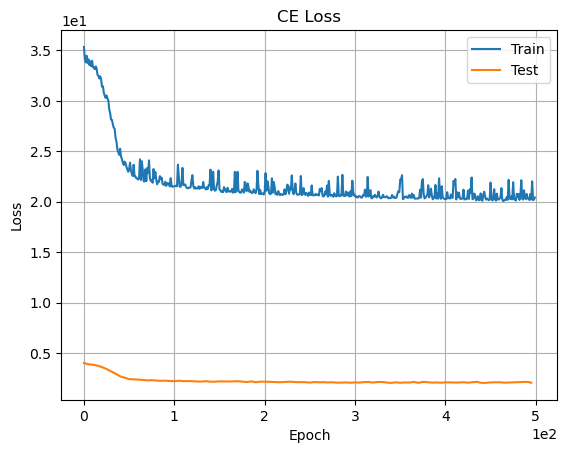

In [15]:
plt.figure()
plt.clf()
plt.plot(range(0, NUM_EPOCHS, 1), train_losses, label='Train')
plt.plot(range(0, NUM_EPOCHS, TEST_INTERVAL), test_losses, label='Test')
plt.legend()
plt.grid()
plt.title('CE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0)) # Apply scientific notation
plt.show()

In [17]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,34.5,0,0,Q
1,3,female,47.0,1,0,S
2,2,male,62.0,0,0,Q
3,3,male,27.0,0,0,S
4,3,female,22.0,1,1,S


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [31]:
output = test_raw[["PassengerId"]]

preds = net(X_test_tensor).argmax(1).detach().numpy()

output["Survived"] = preds

output.to_csv("./outputs/submission.csv", index=False)

C:\Users\02485955\AppData\Local\Temp\ipykernel_32620\4069029542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output["Survived"] = preds
